In [75]:
ALGORITHM = 'XG Boost'
ALGORITHM_DETAIL = 'random search'
VERSION = '02'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [76]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', XGBRegressor(seed=20))
])

In [77]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    import functions_20221012
    from functions_20221012 import set_csv_directory

    set_csv_directory('final_split')

debug_mode = False

In [78]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

booleans = []
floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation']
categories = ['tenure.tenureType']

columns = []
columns.extend(booleans)
columns.extend(floats)
columns.extend(categories)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation', 'tenure.tenureType']
label ->  Price


In [79]:
filename = f'df_listings_v{VERSION}.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):
    retrieval_type = None

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', remote_pathname)
    else:
        try:
            inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
            retrieval_type = 'tidy'
            print('loaded data from', df_pathname_tidy)
        except:
            print(f"WARNING: Failed to retrieved stored data for version {VERSION}, creating new source data.")
            inDF = functions_20221012.get_combined_dataset(HOW='inner', early_duplicates=True,
                                                           folder_prefix=folder_prefix)
            inDF.to_csv(df_pathname_raw)
            retrieval_type = 'raw'

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index

#X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(get_source_dataframe(), return_index=True, drop_nulls=False)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape,

In [80]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = functions_20221012.add_supplements(df)
    df.to_csv(df_pathname_raw)
    df = functions_20221012.tidy_dataset(df, version=int(VERSION))

    df = df[columns]

    df.to_csv(df_pathname_tidy)

print(df.shape)
df[:5]

df_orig.merge(df, how='inner', left_index=True, right_index=True)

print(df.index)

loaded data from ../../data/final/df_listings_v02.csv
(52117, 7)
Int64Index([ 14520525,  27953107,  33593487,  35271294,  35429088,  44749111,
             46204665,  49020666,  49036279,  49303873,
            ...
            126173423, 126173600, 126175973, 126178769, 126179018, 126179672,
            126180107, 126180704, 126180962, 126181118],
           dtype='int64', length=52117)


In [81]:
df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
14520525,550000.0,51.52995,-0.207020,3.0,1.0,0.274316,LEASEHOLD
27953107,400000.0,51.54939,-0.482600,2.0,2.0,0.305845,LEASEHOLD
33593487,579950.0,51.44718,-0.338770,2.0,1.0,0.438045,FREEHOLD
35271294,370000.0,51.449568,-0.140154,2.0,1.0,0.399307,LEASEHOLD
35429088,599950.0,51.57703,-0.141230,2.0,1.0,0.238187,NaN
...,...,...,...,...,...,...,...
126179672,600000.0,51.35717,-0.074740,3.0,2.0,0.545665,LEASEHOLD
126180107,419999.0,51.531415,-0.052964,2.0,1.0,0.191407,LEASEHOLD
126180704,475000.0,51.543141,0.011498,2.0,1.0,0.308609,LEASEHOLD
126180962,450000.0,51.592105,-0.008233,NaN,1.0,0.476935,FREEHOLD


In [82]:
df.isnull().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms              1742
bathrooms             3173
nearestStation           0
tenure.tenureType     3402
dtype: int64

In [83]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52117 entries, 14520525 to 126181118
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               52117 non-null  float64
 1   location.latitude   52117 non-null  object 
 2   location.longitude  52117 non-null  float64
 3   bedrooms            50375 non-null  float64
 4   bathrooms           48944 non-null  float64
 5   nearestStation      52117 non-null  float64
 6   tenure.tenureType   48715 non-null  object 
dtypes: float64(5), object(2)
memory usage: 5.2+ MB


,Price,location.longitude,bedrooms,bathrooms,nearestStation
count,52117.000000,52117.000000,50375.000000,48944.000000,52117.000000
mean,419854.956790,-0.104810,11.721787,1.177182,0.445245
std,110342.806124,0.731478,2183.166275,0.410552,1.066809
min,100000.000000,-0.498315,1.000000,1.000000,0.000000
25%,330000.000000,-0.211852,1.000000,1.000000,0.224233
50%,425000.000000,-0.104440,2.000000,1.000000,0.363994
75%,500000.000000,-0.011509,3.000000,1.000000,0.557263
max,600000.000000,51.558746,490000.000000,12.000000,192.431869


In [84]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 52117 ==> 47444


,count,mean,std,min,25%,50%,75%,max
Price,47444.0,424032.547382,108060.063745,100000.000000,345000.000000,425000.000000,511500.000000,600000.000000
location.latitude,47444.0,51.496962,0.077034,51.298317,51.438814,51.499890,51.555916,51.683185
location.longitude,47444.0,-0.113297,0.156316,-0.498315,-0.210785,-0.102333,-0.010485,0.279726
bedrooms,47444.0,1.990557,0.828428,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,47444.0,1.182173,0.410188,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,47444.0,0.439824,0.354467,0.000000,0.226450,0.367506,0.558826,16.168861


In [85]:
df.isna().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms                 0
bathrooms                0
nearestStation           0
tenure.tenureType     2780
dtype: int64

In [86]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

47444 ==> 44664


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation
count,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000
mean,424197.633598,51.496602,-0.113125,1.989208,1.181332,0.439504
std,107989.580699,0.077221,0.155684,0.827142,0.409031,0.353470
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000
25%,345000.000000,51.438246,-0.210584,1.000000,1.000000,0.226771
50%,425000.000000,51.498681,-0.101934,2.000000,1.000000,0.367875
75%,515000.000000,51.555979,-0.010933,3.000000,1.000000,0.558693
max,600000.000000,51.683185,0.279726,7.000000,5.000000,16.168861


In [87]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(40197, 9) (4467, 9) (40197, 1) (4467, 1) (40197, 1) (4467, 1) (40197, 1) (4467, 1)


In [88]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [89]:
from time import time

#pipe.fit(X_train, y_train)

model = XGBRegressor()
#model.fit(X_train, y_train)
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [229]:

from sklearn.pipeline import Pipeline

# Best Score:  0.30582573121661794
# Best Score:  {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': True}
# Best Score:  Lasso(alpha=10, tol=0.001, warm_start=True)
# Best Score:  138

options_block = {
    'objective': 'reg:squarederror',
    'base_score': None,
    #'booster': ['gbtree', 'gblinear', 'dart'],
    'callbacks': None,
    #'colsample_bylevel': [0.1, 0.3, 0.5, 0.7, 1],
    #'colsample_bynode': [0.1, 0.3, 0.5, 0.7, 1],
    #'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 1],
    'early_stopping_rounds': None,
    'enable_categorical': False,
    'eval_metric': None,
    #'gamma': [0,10,100,1000],
    # 'gpu_id': None,
    # 'grow_policy': None,
    # 'importance_type': None,
    # 'interaction_constraints': None,
    # 'learning_rate': None,
    # 'max_bin': None,
    # 'max_cat_to_onehot': None,
    #'max_delta_step': [1,2,5,10,30],
    #'max_depth': [1,3,6,10,30],
    #'max_leaves': None,
    #'min_child_weight': [1,2,5,10,30],
    ###'missing': nan,
    #'monotone_constraints': None,
    'n_estimators': 100,
    # 'n_jobs': None,
    # 'num_parallel_tree': None,
    # 'predictor': None,
    # 'random_state': None,
    # 'reg_alpha': [0,1,2,5,10,30],
    # 'reg_lambda': [1,2,5,10,30],
    # 'sampling_method': ['uniform','subsample','gradient_based'],
    # 'scale_pos_weight': [0.5,1,2],
    # 'subsample': [0.1, 0.3, 0.5, 0.7, 1],
    # 'tree_method': ['auto','approx','hist','gpu_hist','exact'],
    # 'validate_parameters': False,
    'verbosity': 1}

options_block = {
    'objective': 'reg:squarederror',
    # 'base_score': None,
    # 'booster': None,
    # 'callbacks': None,
    # 'colsample_bylevel': None,
    # 'colsample_bynode': None,
    # 'colsample_bytree': None,
    # 'early_stopping_rounds': None,
    # 'enable_categorical': False,
    # 'eval_metric': None,
    # 'gamma': None,
    # 'gpu_id': None,
    # 'grow_policy': None,
    # 'importance_type': None,
    # 'interaction_constraints': None,
    # 'learning_rate': None,
    # 'max_bin': None,
    # 'max_cat_to_onehot': None,
    # 'max_delta_step': None,
    # 'max_depth': None,
    'max_depth': [1, 3, 6, 10, 30],
    # 'max_leaves': None,
    # 'min_child_weight': None,
    ###'missing': nan,
    # 'monotone_constraints': None,
    'n_estimators': 100,
    # 'n_jobs': None,
    # 'num_parallel_tree': None,
    # 'predictor': None,
    # 'random_state': None,
    # 'reg_alpha': None,
    # 'reg_lambda': None,
    # 'sampling_method': None,
    # 'scale_pos_weight': None,
    # 'subsample': None,
    # 'tree_method': None,
    #'tree_method': ['auto', 'approx', 'hist', 'gpu_hist', 'exact'],
    'tree_method': ['auto', 'approx', 'hist', 'exact'],
    # 'validate_parameters': None,
    'verbosity': 1}

param_grid = {}
for each in options_block:
    if type(options_block[each]) == list:
        param_grid['model__' + each] = options_block[each]
    elif options_block[each] == None:
        #print (f'skipping {each} because value is {options_block[each]}')
        param_grid['model__' + each] = [options_block[each]]
    else:
        param_grid['model__' + each] = [options_block[each]]
#param_grid

cv = 3
n_jobs = 1
verbose = 1
refit = True

#grid = RandomizedSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)

# temp override
cv = 2

gs = RandomizedSearchCV(pipe, param_grid, cv=cv, n_jobs=n_jobs,
                        verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                        return_train_score=True, n_iter=30),
gs

grid_result = gs[0].fit(X_train, y_train)


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 25 is smaller than n_iter=30. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 25 candidates, totalling 50 fits
[14:13:31] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:13:31] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:13:38] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:13:38] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:13:49] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:13:49] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:13:58] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:13:58] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:17:28] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[14:17:28] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_stre

In [230]:
pipe = grid_result.best_estimator_
timings = []

t0 = time()
pipe.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[5.500423431396484]
5.500423431396484


In [231]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'model__verbosity': 1, 'model__tree_method': 'auto', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 10}
0.488 (+/-0.005) for {'model__verbosity': 1, 'model__tree_method': 'auto', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.487 (+/-0.005) for {'model__verbosity': 1, 'model__tree_method': 'approx', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.487 (+/-0.005) for {'model__verbosity': 1, 'model__tree_method': 'hist', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
nan (+/-nan) for {'model__verbosity': 1, 'model__tree_method': 'gpu_hist', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.488 (+/-0.005) for {'model__verbosity': 1, 'model__tree_method': 'exact', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.607 (+

In [232]:
y_pred = pipe.predict(X_test)

In [233]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------XG Boost----------
R square Accuracy 0.6829553615082685
Mean Absolute Error Accuracy 45160.15766663868
Mean Squared Error Accuracy 3627875443.187743
Root Mean Squared Error 60231.847416360586


In [234]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [235]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
124597034.0,285000.0,347248.31250,62248.31250,21.841513,17.926167
82883871.0,500000.0,568619.06250,68619.06250,13.723812,12.067668
123298382.0,435000.0,451795.50000,16795.50000,3.861034,3.717501
119192408.0,300000.0,304086.43750,4086.43750,1.362146,1.343841
116845355.0,600000.0,541443.62500,58556.37500,9.759396,10.814861
...,...,...,...,...,...
123467048.0,449950.0,522935.93750,72985.93750,16.220900,13.956956
114663482.0,375000.0,351018.28125,23981.71875,6.395125,6.832043
123013478.0,500000.0,479593.12500,20406.87500,4.081375,4.255039


In [236]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType


In [237]:
score = pipe.score(X_test, y_test)
score

0.6829553615082685

In [238]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.6829553615082685

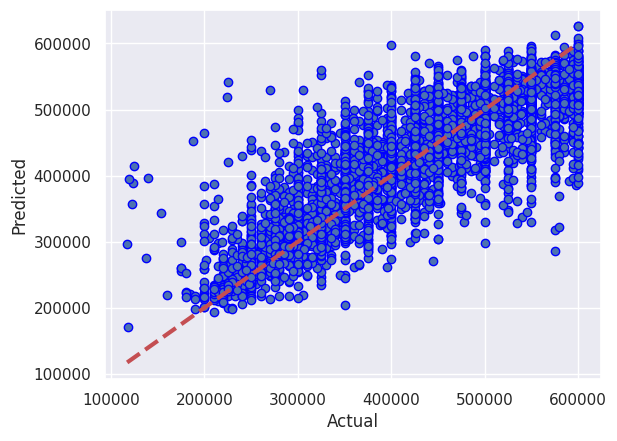

In [239]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [240]:
if False:
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            #return pd.Series({**params, **d})
            return pd.Series({**params, **d, **{'params_full': str(params)}})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]


    import seaborn as sns

    score_summary = score_summary(self=gs, sort_by='max_score')

In [241]:

if False:
    #sns.set(rc={"figure.figsize": (10, 10)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    #total_graphs = len(score_summary)
    # max_horizontal = 4
    # index2 = 0
    # resultant_rows = math.ceil(total_graphs / max_horizontal)
    # #subplots_adjust()
    #
    # #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    best_estimator = score_summary.iloc[0]
    worst_estimator = score_summary.iloc[-1]

    name_best = best_estimator["estimator"]
    params_str = best_estimator["params_full"]
    params_best = ast.literal_eval(params_str)

    name_worst = worst_estimator["estimator"]
    params_str = worst_estimator["params_full"]
    params_worst = ast.literal_eval(params_str)

    KNeighborsRegressor().set_params()

    best_pipe = make_pipe(name_best)
    worst_pipe = make_pipe(name_worst)

    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[0],
                    s=100).set(
        title=f'"BEST" model: {name_best} \n{params_best}')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[1],
                    s=100).set(
        title=f'"WORST" model: {name_worst} \n{params_worst}')

    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[2],
                    s=100, color='orange')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[2],
                    s=100, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')

    fig.tight_layout()
    plt.show()

if False:
    max_horizontal = 3

    #sns.set()
    #sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    total_graphs = len(score_summary)
    index2 = 0
    resultant_rows = math.ceil(total_graphs / max_horizontal)
    #subplots_adjust()

    #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    for (key, next_estimator), index in zip(score_summary.iterrows(), range(total_graphs)):
        if index % (max_horizontal * 2) == 0 and index != 0:
            index2 = 0
            fig.tight_layout()
            plt.show()
            #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
            fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

        name_next = next_estimator["estimator"]
        params_str = next_estimator["params_full"]
        params_next = ast.literal_eval(params_str)
        #print("next", params_next)

        if 'noscale' in name_next:
            pipe = Pipeline(steps=[
                ('preprocessor', features_noscale_preprocessor),  # preprocess features
                ('estimator', models_and_params[name_next]["model"]),
            ])  # start the training
        else:
            pipe = Pipeline(steps=[
                ('preprocessor', features_preprocessor),
                ('estimator', models_and_params[name_next]["model"]),  # preprocess features
            ])  # start the training

        # 0 ==> 0,0
        # 1 ==> 0,1
        # 2 ==> 1,0
        x_coor = index2 // max_horizontal
        y_coor = index2 % max_horizontal

        coordinates = axes[x_coor][y_coor]
        #sns.lineplot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], hue='red', lw=3)
        sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=coordinates, color='red')
        sns.scatterplot(x=y_test, y=pipe.set_params(**params_next).fit(X_train, y_train).predict(X_test),
                        ax=coordinates, s=100).set(
            title=f'({index}) {"BEST" if index == 0 else "next"} model: {name_next} \n{params_next}')
        #if index == 11: break
        index2 += 1

    fig.tight_layout()
    plt.show()

In [242]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': grid_result.best_params_
}
import json


def get_results():
    results_filename = '../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)
    return results_json


def update_results(results_json, new_results):
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()
    try:
        first_run_date = str(datetime.now())
        first_run_date = results_json[key]['date']
        first_run_date = results_json[key]['first run']
    except:
        pass

    try:
        max_score = -1000
        max_params = 'NOT APPLICABLE'
        max_score = results_json[key]['Score']
        max_params = results_json[key]['params']
        max_score = results_json[key]['max score']
        max_params = results_json[key]['max params']
    except:
        pass

    results['first run'] = first_run_date
    if max_score > results_json[key]['Score']:
        new_results['suboptimal'] = 'suboptimal'
    elif max_score == results_json[key]['Score']:
        if results_json[key]['params'] != new_results['params']:
            new_results['max params'] = 'MULTIPLE PARAM OPTIONS'
        else:
            new_results['max params'] = results_json[key]['params']
            new_results['max score'] = results_json[key]['Score']
            new_results['suboptimal'] = 'pending'
    else:
        new_results['max params'] = results_json[key]['params']
        new_results['max score'] = results_json[key]['Score']
        new_results['suboptimal'] = 'pending'

    results_json[key] = new_results

    results_filename = '../../results/results.json'
    with open(results_filename, 'w') as file:
        file.write(json.dumps(results_json, indent=4))


if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results)

results

{'Score': 0.6829553615082685,
 'R square Accuracy': 0.6829553615082685,
 'Mean Absolute Error Accuracy': 45160.15766663868,
 'Mean Squared Error Accuracy': 3627875443.187743,
 'Root Mean Squared Error': 60231.847416360586,
 'Training Time': 5.500423431396484,
 'random_state': 101,
 'date': '2022-10-13 14:18:26.765461',
 'params': {'model__verbosity': 1,
  'model__tree_method': 'auto',
  'model__objective': 'reg:squarederror',
  'model__n_estimators': 100,
  'model__max_depth': 10},
 'first run': '2022-10-13 13:42:33.640185',
 'max params': 'MULTIPLE PARAM OPTIONS'}